In [1]:
import os
import time
import pandas as pd
import numpy as np
import sys
import warnings
import logging
import utils
from tqdm import tqdm
from data_reader import LoadCSV
from data_preprocess import data_preprocess
from models import evaluate_model, get_classifiers, get_samplers, compute_fbeta
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from IPython.display import display
import seaborn as sns

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
# Read Data
start = time.time()
applicant_data_df = LoadCSV(data_path="./applicant.csv")()
loan_data_df = LoadCSV(data_path="./loan.csv")()
print("Time taken to load data: {}".format(round(time.time() - start, 3)))
# Merge applicant data with loan data on applicant_id
start = time.time()
data_df = pd.merge(applicant_data_df, loan_data_df, on='applicant_id')
print("Time taken to merge data: {}".format(round(time.time() - start, 3)))
display(data_df)

Time taken to load data: 0.022
Time taken to merge data: 0.008


,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,...,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
0,1469590,67,male,single,1,own,4,skilled employee / official,7 years,NaN,...,electronic equipment,1169000,4,real estate,0,0,NaN,2,critical/pending loans at other banks,0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1 year,4 years,...,electronic equipment,5951000,2,real estate,0,0,NaN,1,existing loans paid back duly till now,1
2,1432761,49,male,single,2,own,3,unskilled - resident,4 years,7 years,...,education,2096000,2,real estate,0,0,NaN,1,critical/pending loans at other banks,0
3,1207582,45,male,single,2,for free,4,skilled employee / official,4 years,7 years,...,FF&E,7882000,2,building society savings agreement/life insurance,0,1,NaN,1,existing loans paid back duly till now,0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1 year,4 years,...,new vehicle,4870000,3,NaN,0,0,NaN,2,delay in paying off loans in the past,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1880194,31,female,divorced/separated/married,1,own,4,unskilled - resident,4 years,7 years,...,FF&E,1736000,3,real estate,0,0,NaN,1,existing loans paid back duly till now,0
996,1114064,40,male,divorced/separated,1,own,4,management / self-employed / highly qualified ...,1 year,4 years,...,used vehicle,3857000,4,building society savings agreement/life insurance,0,0,NaN,1,existing loans paid back duly till now,0
997,1758046,38,male,single,1,own,4,skilled employee / official,7 years,NaN,...,electronic equipment,804000,4,car or other,0,0,NaN,1,existing loans paid back duly till now,0
998,1824545,23,male,single,1,for free,4,skilled employee / official,1 year,4 years,...,electronic equipment,1845000,4,NaN,0,0,NaN,1,existing loans paid back duly till now,1


# Exploratory Data Analysis
Let's explore the categorical and numerical features of the data.

In [3]:
# Print information and identify categorical and numerical features
display(data_df.describe(include='all'))
print(data_df.info())

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,...,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
count,1.000000e+03,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,938,747,...,988,1.000000e+03,1000.000000,846,1000.000000,1000.000000,186,1000.000000,1000,1000.000000
unique,NaN,NaN,2,4,NaN,3,NaN,4,4,4,...,9,NaN,NaN,3,NaN,NaN,2,NaN,5,NaN
top,NaN,NaN,male,single,NaN,own,NaN,skilled employee / official,1 year,4 years,...,electronic equipment,NaN,NaN,car or other,NaN,NaN,bank,NaN,existing loans paid back duly till now,NaN
freq,NaN,NaN,690,548,NaN,713,NaN,630,339,339,...,280,NaN,NaN,332,NaN,NaN,139,NaN,530,NaN
mean,1.514763e+06,35.546000,NaN,NaN,1.155000,NaN,2.845000,NaN,NaN,NaN,...,NaN,3.271258e+06,2.973000,NaN,0.041000,0.052000,NaN,1.407000,NaN,0.300000
std,2.286764e+05,11.375469,NaN,NaN,0.362086,NaN,1.103718,NaN,NaN,NaN,...,NaN,2.822737e+06,1.118715,NaN,0.198389,0.222138,NaN,0.577654,NaN,0.458487
min,1.105364e+06,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,...,NaN,2.500000e+05,1.000000,NaN,0.000000,0.000000,NaN,1.000000,NaN,0.000000
25%,1.321398e+06,27.000000,NaN,NaN,1.000000,NaN,2.000000,NaN,NaN,NaN,...,NaN,1.365500e+06,2.000000,NaN,0.000000,0.000000,NaN,1.000000,NaN,0.000000
50%,1.529114e+06,33.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN,NaN,...,NaN,2.319500e+06,3.000000,NaN,0.000000,0.000000,NaN,1.000000,NaN,0.000000
75%,1.707752e+06,42.000000,NaN,NaN,1.000000,NaN,4.000000,NaN,NaN,NaN,...,NaN,3.972250e+06,4.000000,NaN,0.000000,0.000000,NaN,2.000000,NaN,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   applicant_id                                              1000 non-null   int64 
 1   Primary_applicant_age_in_years                            1000 non-null   int64 
 2   Gender                                                    1000 non-null   object
 3   Marital_status                                            1000 non-null   object
 4   Number_of_dependents                                      1000 non-null   int64 
 5   Housing                                                   1000 non-null   object
 6   Years_at_current_residence                                1000 non-null   int64 
 7   Employment_status                                         1000 non-null   object
 8   Has_been_employed_for_at_leas

First, let's check class distibution from label column of the training dataset:

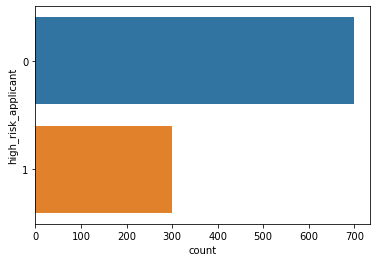

In [4]:
sns.countplot(y='high_risk_applicant', data=data_df, palette=['tab:blue', 'tab:orange'])
pyplot.show()

With 700:300 class distribution, we can infer that the dataset is imbalanced where positive class $(label=1)$ is in minority. This would require imbalance learning of machine learning models. Moreover, since the cost of misclassifying high-risk applicants as low-risk is more, we would also require cost-sensitive learning of our models.

One of the first things we can do is inspect which features provide information towards predicting the target variable. For this, we can perform bivariate analysis of features with target to get an initial picture.

### Categorical Data Analysis

count                                       1000
unique                                         5
top       existing loans paid back duly till now
freq                                         530
Name: Loan_history, dtype: object


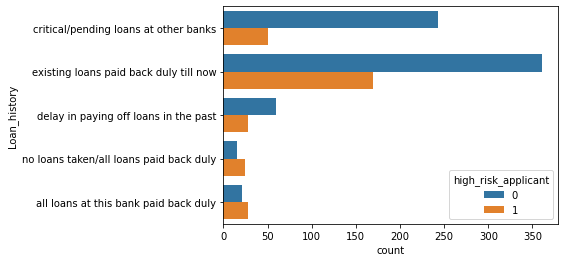

In [5]:
target_col = 'high_risk_applicant'
col_name = 'Loan_history'
print(data_df[col_name].describe())
sns.countplot(y=col_name, hue=target_col, data=data_df, palette=['tab:blue', 'tab:orange'])
pyplot.show()

We can observe some interesting traits from this bar chart. There are more low-risk than high-risk applicants with critical/pending history which suggests that even if an applicant has critical credit history, they still tend to be at lower risk (i.e. they are more creditworthy. Moreover, applicants who have not taken loans or duly paid loans at this bank appear to be less creditworthy (of high risk)**(Answer 2a)**. This is in contrast to common belief that loans should be sanctioned to people who have duly paid loans in the past, not to applicants who have critical history. It seems like other features in the dataset are having more impact than `Loan_history` on credit-worthiness of an applicant.

### Numerical Data Analysis

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Primary_applicant_age_in_years, dtype: float64


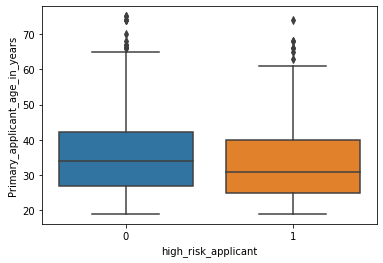

In [6]:
column_name = 'Primary_applicant_age_in_years'
print(data_df[column_name].describe())
sns.boxplot(y=column_name, x=target_col, data=data_df, palette=['tab:blue', 'tab:orange'])
# sns.swarmplot(y='Primary_applicant_age_in_years', x='high_risk_applicant', data=data_df, palette=['tab:blue', 'tab:orange'])
pyplot.show()

We can observe some interesting traits from this graph. Most notably, we can see that 50% of low-risk applicants lie in the age group of 28-42 and 50% of high-risk applicants lie in the age group of 25-39. The corresponding difference in the heights of the boxes suggests that younger people tend to be riskier than older people when considered for loan (or older people tend to be more creditworthy)**(Answer 2b)**.

Additional note-worthy observations from similarly analysing following features of dataset:
- *Months_loan_taken_for*: High-risk applicants tend to take loan for more number of months.
- *Principal_loan_amount*: Applicants tend to be considered high-risk if they apply for high-value loans.

### Data Pre-Processing
- Encode Categorical Features
- Drop Instances with no Target Labels
- Mark NA values of Categorical Features with empty string and Impute missing values of numerical features
- Normalise Feature Values using MinMaxScalar

In [7]:
start = time.time()
drop_features = ['applicant_id', 'loan_application_id', 'Telephone']
column_label_dict = {
        'Savings_account_balance': {
            '': 0,
            'Low': 1,
            'Medium': 2,
            'High': 3,
            'Very high': 4
        }
    }
feature_req_onehot_enc = ['Gender', 'Marital_status', 'Housing', 'Purpose', 'Property', 'Employment_status', 'Loan_history', 'Other_EMI_plans']
data_preprocess_obj = data_preprocess(data_df, drop_columns=drop_features)
processed_df = data_preprocess_obj.process_data()
# Note: implemented one-hot considers missing values of categorical variables as separate class.
# For the given data, onehot_encode= List[<ColName>], None
X, y, = data_preprocess_obj.get_df_X_y(processed_df, label_column='high_risk_applicant', onehot_encode=feature_req_onehot_enc,
                                       column_label_dict=column_label_dict)
print("Time taken to process data: {}".format(round(time.time() - start, 3)))
n_samples, n_features = np.shape(X)
print("Number of instances: {}\nNumber of features: {}".format(n_samples, n_features))

Time taken to process data: 0.034
Number of instances: 1000
Number of features: 50


### Correlation Analysis

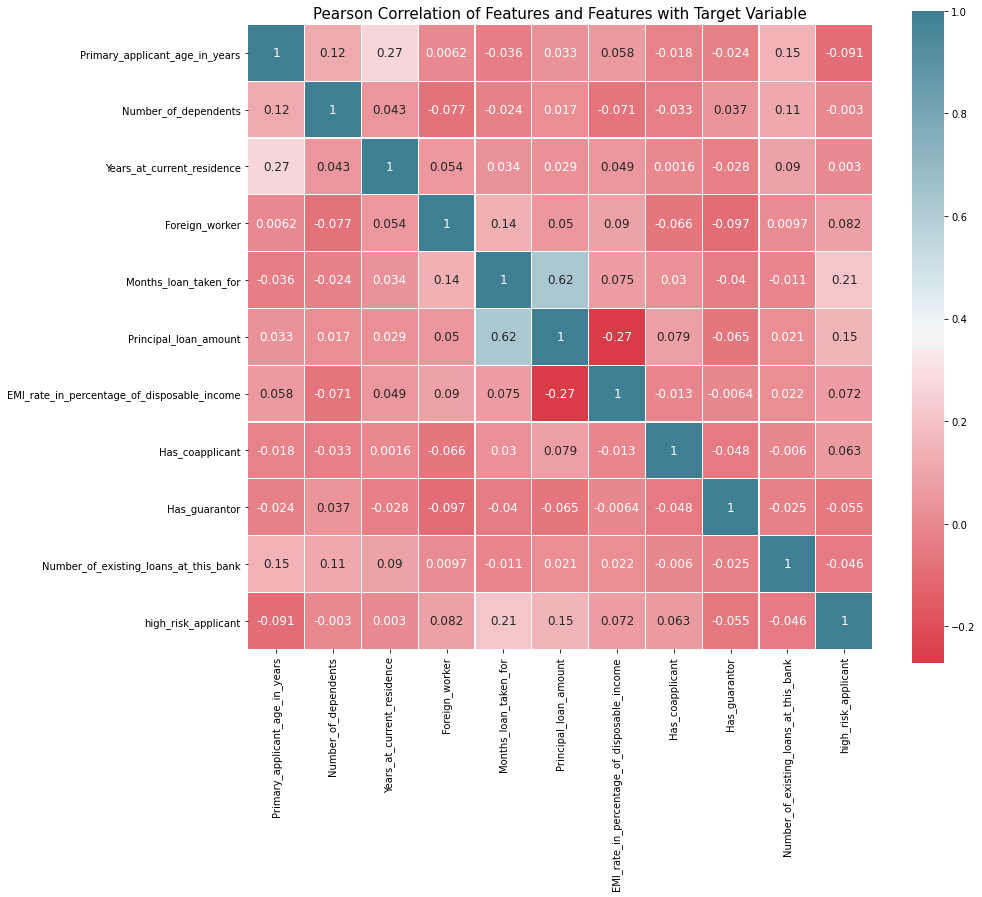

In [8]:
corr_df = pd.concat([data_preprocess_obj.processed_df[data_preprocess_obj.numerical], data_preprocess_obj.y], axis=1)
pyplot.figure(figsize=(14,12))
pyplot.title('Pearson Correlation of Features and Features with Target Variable', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(corr_df.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
pyplot.show()

**Feature-Feature Correlation**: From correlation analysis, we can identify positive, negative and neutral corrleation between numerical features of the dataset. For example, `Principal Loan Amount` and `Months Loan Taken For` has positive correlation which is expected, since with increase in months loan taken for, principal loan amount will also go up. On the other hand, `EMI_rate_in_percentage_of_disposable_income` has negative correlation with `Principal Loan Amount`. 

**Feature-Target Correlation**: From this we can further confirm that, `Primary_applicant_age_in_years` is negatively correlated with risk in lending loan (or positively correlated with creditworthiness)**(Answer 2b)**. Other noticeable features which have positive correlation with risk are `Months Loan taken for` and `Principal Loan Amount` which suggests that applicant is likely to exhibit higher risk in loan repayment if the net amount to be paid back to lender is high. Interestingly, we can also see that if the applicant has a `coapplicant`, risk in lending increases, while if the applicant has a `guarantor`, the risk in lending decreases. **(Answer 2c)** Moreover, if the applicant has  more number of existing loans (`credit accounts`) at this bank, lending loan is less riskier (depicted by negative correlation of `-0.046`).

*Avoid multi-collinearity for generalised linear models. Tree-based models are not affected.*

# Feature Importance for EDA

Based on defined Machine Learning models in `models.py`, lets visualise importance scores learned by them for each feature of the training data.

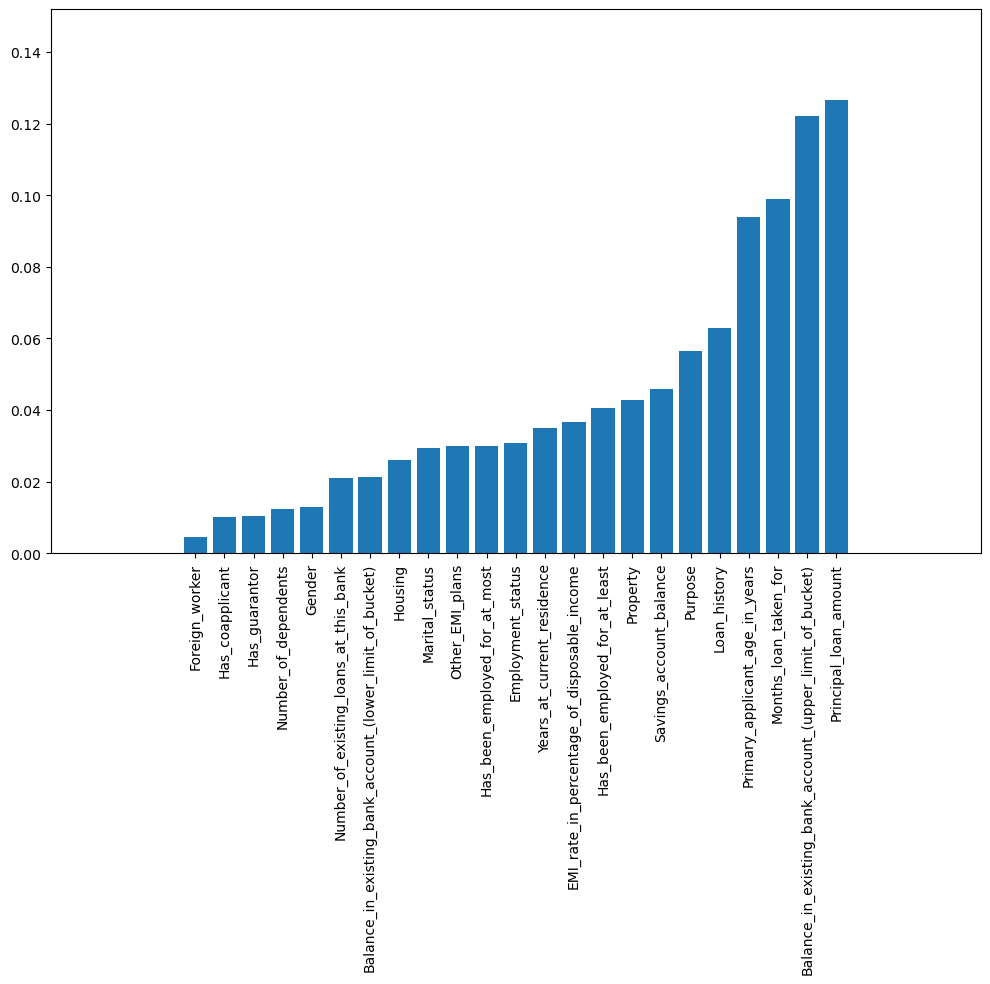

In [9]:
from utils import feature_importance_plot
pyplot.rcParams['figure.figsize'] = [12, 8]
pyplot.rcParams['figure.dpi'] = 100
temp_obj = data_preprocess(data_df, drop_columns=drop_features)
temp_df = temp_obj.process_data()
X_vis, y_vis, = temp_obj.get_df_X_y(temp_df, label_column='high_risk_applicant', onehot_encode=[], column_label_dict=column_label_dict)
feature_importance_plot('R-Forest', X_vis, y_vis, temp_obj.processed_df.columns, regression_based=False, tree_based=True, no_intrinsic_selection=False, save_fig=False)

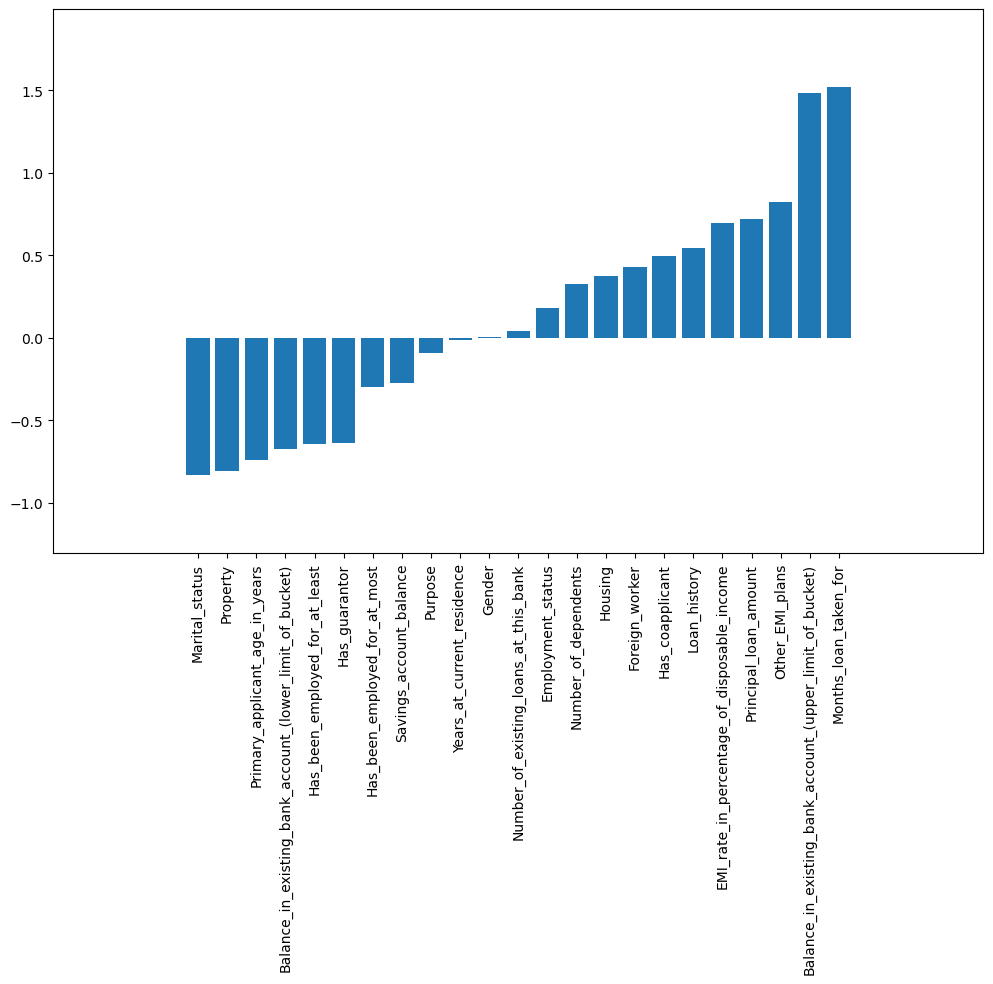

In [10]:
feature_importance_plot('LogReg', X_vis, y_vis, temp_obj.processed_df.columns, regression_based=True, tree_based=False, no_intrinsic_selection=False, save_fig=False)

In [11]:
# feature_importance_plot('MLP', X_vis, y_vis, temp_obj.processed_df.columns, regression_based=False, tree_based=False, no_intrinsic_selection=True, save_fig=False)

### Model Evaluation
First, we can evaluate various ML models on the dataset and observe their performance on full dataset. With XGBoost performing the best (analysis of model performance provided in attached write-up.), we will use this model for further analysis.

In [12]:
print("Evaluating Models...")
from main import test_samplers_with_clfs
test_samplers_with_clfs(get_classifiers(), {"RENN": get_samplers()['RENN']}, X, y, num_splits=10, make_plots=False)

Evaluating Models...
Model: AdaBoost_RENN, Avg Score: 0.696 (+/- 0.088), Time Taken: 12.87s
Model: Linear-SVM_RENN, Avg Score: 0.701 (+/- 0.087), Time Taken: 1.53s
Model: RBF-SVM_RENN, Avg Score: 0.697 (+/- 0.033), Time Taken: 1.74s
Model: D-Tree_RENN, Avg Score: 0.681 (+/- 0.1), Time Taken: 1.31s
Model: R-Forest_RENN, Avg Score: 0.708 (+/- 0.074), Time Taken: 10.99s
Model: QDA_RENN, Avg Score: 0.657 (+/- 0.105), Time Taken: 1.37s
Model: LDA_RENN, Avg Score: 0.69 (+/- 0.094), Time Taken: 1.45s
Model: MLP_RENN, Avg Score: 0.68 (+/- 0.084), Time Taken: 16.97s
Model: GaussNB_RENN, Avg Score: 0.468 (+/- 0.207), Time Taken: 1.3s
Model: LogReg_RENN, Avg Score: 0.689 (+/- 0.101), Time Taken: 1.41s
Model: Ridge_RENN, Avg Score: 0.689 (+/- 0.096), Time Taken: 1.85s
Model: XGBoost_RENN, Avg Score: 0.714 (+/- 0.076), Time Taken: 6.32s
Model: Dummy(1)_RENN, Avg Score: 0.682 (+/- 0.0), Time Taken: 1.35s
Model: Dummy(0)_RENN, Avg Score: 0.0 (+/- 0.0), Time Taken: 1.28s


In [13]:
from sklearn.feature_selection import SelectFromModel
label_col = {'high_risk_applicant'}
no_info_features = ['applicant_id', 'loan_application_id', 'Telephone']

def get_score(drop_features, model, onehot_to_enc=[]):
    temp_obj = data_preprocess(data_df, drop_columns=drop_features)
    temp_df = temp_obj.process_data()
    X_vis, y_vis, = temp_obj.get_df_X_y(temp_df, label_column='high_risk_applicant', onehot_encode=onehot_to_enc, column_label_dict=column_label_dict)
    scores = evaluate_model(X_vis, y_vis, model, num_splits=10)
    print("XGBoost: Avg Score = {} (+/- {})".format(round(scores.mean(), 3), round(scores.std() * 2, 3)))

xgboost = Pipeline(steps=[('s', get_samplers()['RENN']), ('m', get_classifiers()['XGBoost'])])
start = time.time()
get_score(no_info_features, xgboost)
print("Computation Time: {}s".format(round(time.time()-start ,2)))

XGBoost: Avg Score = 0.714 (+/- 0.064)
Computation Time: 4.85s


This is the performance of model with all features but non-informative ones. We would like to see if we can achieve or outperform this with lesser number of features, identified based on feature analysis.

### Feature Plot Analysis and FICO scoring model
For preliminary assumption, we can use FICO's credit scoring model. It suggests that Payment History, Debt Owed, Length of credit history, Types of Credit and New Credits are some of the major attributes that decide on lending risk for an applicant. Features of our dataset that play a similar role in specifying applicant's credit history and owned debt are Months Loan Taken For, Principal Loan Amount, Other EMI Plans, Number of existing loans and Loan history. Let's check if they alone are sufficent in predicting high risk/low risk.

In [14]:
primary_features = ['Months_loan_taken_for', 'Principal_loan_amount', 'Other_EMI_plans', 'Number_of_existing_loans_at_this_bank', 'Loan_history']
drop_features = list(set(data_df.columns) - set(primary_features) - label_col)
start = time.time()
get_score(drop_features, xgboost)
print("Computation Time: {}s".format(round(time.time()-start ,2)))

XGBoost: Avg Score = 0.675 (+/- 0.101)
Computation Time: 4.01s


To futher boost the performance, we can make use of the exploratory data analysis conducted so far. We can observe from the plots that Age and Balance in existing account (Upper Limit) are also notably influencing the prediction of risk. Let's also include these features and observe the performance.

In [15]:
secondary_features = ['Primary_applicant_age_in_years', 'Balance_in_existing_bank_account_(upper_limit_of_bucket)']
# secondary_features = ['Employment_status', 'Primary_applicant_age_in_years','Balance_in_existing_bank_account_(upper_limit_of_bucket)']
drop_features = list(set(data_df.columns) - set(primary_features) - set(secondary_features) - label_col)
start = time.time()
get_score(drop_features, xgboost)
print("Computation Time: {}s".format(round(time.time()-start ,2)))

XGBoost: Avg Score = 0.714 (+/- 0.064)
Computation Time: 3.36s


We can see that with just 7 features identified based on EDA, we are able to achieve performance equal to that of full model trained on all 23 (informative) features. This is quite crucial in addressing redundancy in data and saving computation time of the model when deployed for real-time use. 

**(Future Work)** There exists many other solutions to feature selection, which we can also use as part of future work. For instance, entropy-based information of features and target variable is used to compute scores like FCBF, Mutual Information etc. that weigh redundancy, relevancy and complementarity of features in predicting the target variable. 

Lets now re-evalauate our models with selected features.

Evaluating Models...
Model: AdaBoost_RENN, Avg Score: 0.685 (+/- 0.087), Time Taken: 10.84s
Model: Linear-SVM_RENN, Avg Score: 0.657 (+/- 0.117), Time Taken: 0.38s
Model: RBF-SVM_RENN, Avg Score: 0.696 (+/- 0.093), Time Taken: 0.38s
Model: D-Tree_RENN, Avg Score: 0.697 (+/- 0.087), Time Taken: 0.28s
Model: R-Forest_RENN, Avg Score: 0.701 (+/- 0.094), Time Taken: 10.35s
Model: QDA_RENN, Avg Score: 0.667 (+/- 0.114), Time Taken: 0.28s
Model: LDA_RENN, Avg Score: 0.675 (+/- 0.125), Time Taken: 0.3s
Model: MLP_RENN, Avg Score: 0.694 (+/- 0.089), Time Taken: 45.98s
Model: GaussNB_RENN, Avg Score: 0.283 (+/- 0.16), Time Taken: 0.36s
Model: LogReg_RENN, Avg Score: 0.694 (+/- 0.102), Time Taken: 0.35s
Model: Ridge_RENN, Avg Score: 0.679 (+/- 0.12), Time Taken: 0.36s
Model: XGBoost_RENN, Avg Score: 0.722 (+/- 0.061), Time Taken: 3.74s
Model: Dummy(1)_RENN, Avg Score: 0.682 (+/- 0.0), Time Taken: 0.38s
Model: Dummy(0)_RENN, Avg Score: 0.0 (+/- 0.0), Time Taken: 0.33s


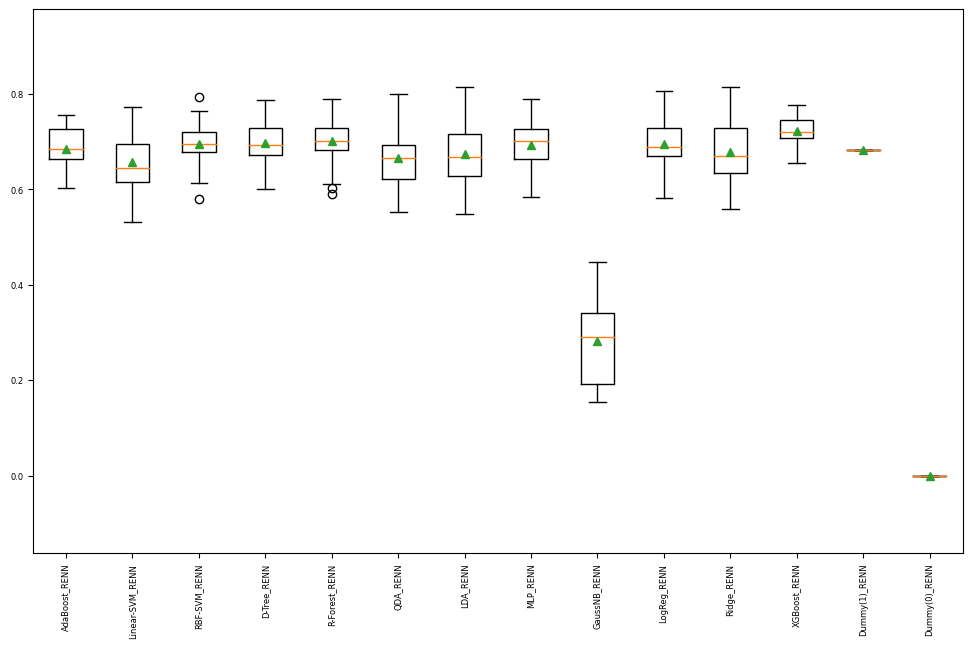

In [16]:
print("Evaluating Models...")
temp_obj = data_preprocess(data_df, drop_columns=drop_features)
temp_df = temp_obj.process_data()
X_red, y = temp_obj.get_df_X_y(temp_df, label_column='high_risk_applicant', onehot_encode=feature_req_onehot_enc, column_label_dict=column_label_dict)
test_samplers_with_clfs(get_classifiers(), {"RENN": get_samplers()['RENN']}, X_red, y, num_splits=10, make_plots=True)

**Conclusion**: With EDA to identify rleationship between features and target variable, we were able to boost the performance of models in terms of F2 score and computation time. We can now use the Gradient Boost model which has the highest F2 score for making predictions. I believe Gradient Boosting is able to outperform other models because it can capture non-linear relationships between features and target and also it uses ensemble learning to build a strong model by iteratively learning from each of its individual weak learners.